# PySpark

## Utworzenie sesji Sparka

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("PySpark") \
    .getOrCreate()

## Ładowanie zdjęć ze wskazanego folderu

In [10]:
path = "data"
df = spark.read.format("image").load(path)

In [11]:
display(df)
df.count()

DataFrame[image: struct<origin:string,height:int,width:int,nChannels:int,mode:int,data:binary>]

16

+--------------------+
|               image|
+--------------------+
|{file:///home/mik...|
|{file:///home/mik...|
|{file:///home/mik...|
|{file:///home/mik...|
|{file:///home/mik...|
|{file:///home/mik...|
|{file:///home/mik...|
|{file:///home/mik...|
|{file:///home/mik...|
|{file:///home/mik...|
|{file:///home/mik...|
|{file:///home/mik...|
|{file:///home/mik...|
|{file:///home/mik...|
|{file:///home/mik...|
|{file:///home/mik...|
+--------------------+

file:///home/mikolaj/Workspace/Detekcja-zmian-uzytkowania-ziemi/data/LC08_L1TP_038032_20230925_20231002_02_T1.jpg


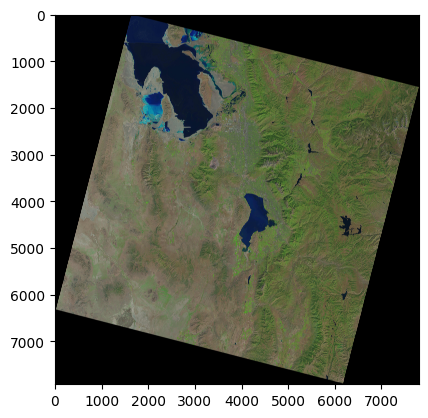

file:///home/mikolaj/Workspace/Detekcja-zmian-uzytkowania-ziemi/data/LC08_L1TP_038032_20130609_20200913_02_T1.jpg


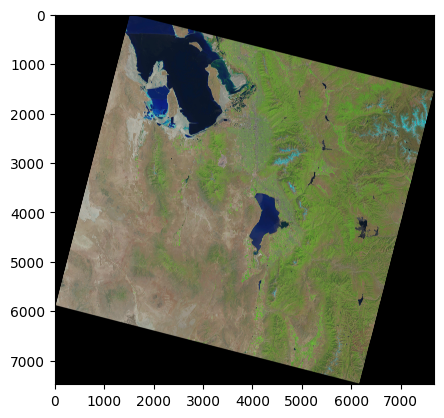

file:///home/mikolaj/Workspace/Detekcja-zmian-uzytkowania-ziemi/data/LC08_L1TP_230062_20190830_20200826_02_T1.jpg


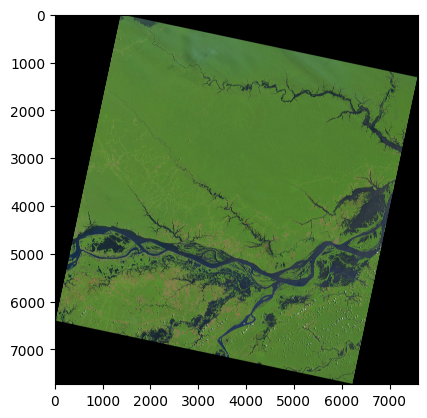

file:///home/mikolaj/Workspace/Detekcja-zmian-uzytkowania-ziemi/data/LC09_L1TP_039031_20230722_20230723_02_T1.jpg


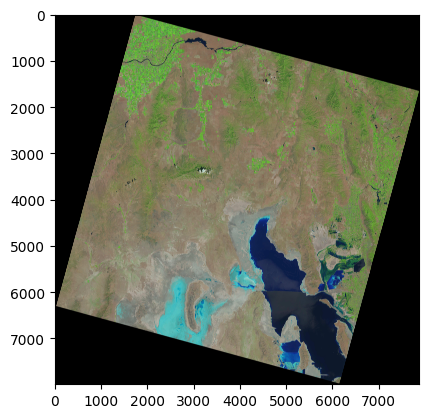

file:///home/mikolaj/Workspace/Detekcja-zmian-uzytkowania-ziemi/data/LC08_L1TP_039031_20160726_20200906_02_T1.jpg


KeyboardInterrupt: 

In [34]:
# wyswietl zdjecia z df
import matplotlib.pyplot as plt
from PIL import Image
import sys

df.show()
for row in df.collect():
    #print(row.image.origin)
    image_path = row.image.origin.split("file://")[1]
    print(image_path)
    image = Image.open(image_path)

    plt.imshow(image)
    plt.show()

